In [1]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

## Parameters

In [2]:
use_clusters = [
    'CA1_Ak5', 'CA1_Chrm3', 'CA1_Kif26a', 'CA1_Ptprg',
    'CA3_Cadm2', 'CA3_Efnb2', 'CA3-St18_Epha5', 'CA3-St18_Nuak1',
    'CA3-St18_Tead1', 'DG_dg-all', 'DG-po_Bcl11a', 'DG-po_Calb2',
    'DG-po_Kctd8', 'Gfra1_Gfra1', 'IG-CA2_Chrm3', 'IG-CA2_Peak1', 'IG-CA2_Xpr1'
]
# 'CA1_Lingo2' not include, because it co-cluster with RHP, probably an incomplete cluster

oddsratio_cutoff = 1.2
lgp_cutoff = 8

expressed_cutoff = 0.05
expressed_portion = 0.2

## Total Motif Enrichment

In [3]:
enriched_motif = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ManualMotifEnrichment/SubType.total_enrichment.msg'
)
enriched_motif = enriched_motif[enriched_motif['SubType'].isin(use_clusters)]
enriched_motif = enriched_motif[
    (enriched_motif['-lgp'] >= lgp_cutoff) & 
    (enriched_motif['oddsratio'] >= oddsratio_cutoff) &
    (enriched_motif['DMRType'] == 'Hypo')]

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


## RNA CPM

In [4]:
cluster_cpm = pd.read_msgpack('/home/hanliu/project/mouse_rostral_brain/study/mCClusterRNACPM/SubType.CPM.msg')
cluster_cpm.index = cluster_cpm.index.map(lambda i: i if i != 'Zfp191' else 'Zfp24')
cluster_cpm.columns = cluster_cpm.columns.map(lambda i: i.replace(' ', '_'))

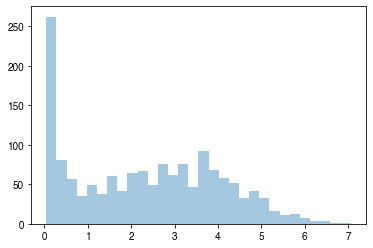

In [5]:
gene_set = set()
for gs in enriched_motif['gene_names']:
    for g in gs.split(','):
        gene_set.add(g)
tf_genes = pd.Index(gene_set)

for g in tf_genes:
    if g not in cluster_cpm.index:
        print(g)
tf_cpm = cluster_cpm.loc[tf_genes, use_clusters]
assert tf_cpm.isna().sum().sum() == 0

a = tf_cpm.values.flat
sns.distplot(np.log1p(a[a > expressed_cutoff]), kde=False, bins=30)
expressed_tf_cpm_judge = tf_cpm > expressed_cutoff

## RNA exp Portion

In [6]:
cluster_exp_portion = pd.read_msgpack('/home/hanliu/project/mouse_rostral_brain/study/mCClusterRNACPM/SubType.exp_portion.msg')
cluster_exp_portion.index = cluster_exp_portion.index.map(lambda i: i if i != 'Zfp191' else 'Zfp24')
cluster_exp_portion.columns = cluster_exp_portion.columns.map(lambda i: i.replace(' ', '_'))


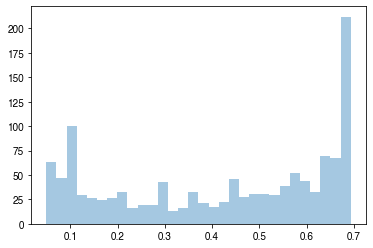

In [7]:
tf_exp_portion = cluster_exp_portion.loc[tf_genes, use_clusters]
assert tf_exp_portion.isna().sum().sum() == 0

a = tf_exp_portion.values.flat
sns.distplot(np.log1p(a[a > expressed_cutoff]), kde=False, bins=30)
expressed_tf_portion_judge = tf_exp_portion > expressed_portion

In [9]:
rna_total_judge = pd.DataFrame(
    np.all([expressed_tf_cpm_judge.values, expressed_tf_portion_judge.values],
           axis=0),
    index=expressed_tf_cpm_judge.index,
    columns=expressed_tf_cpm_judge.columns)

In [12]:
rna_total_judge.sum().sum()

951

## Final Enrichment 

In [18]:
def judge(cluster, gene):
    judges = []
    for g in gene.split(','):
        judges.append(rna_total_judge.loc[g, cluster])
    return any(judges)

In [29]:
enriched_motif = enriched_motif[enriched_motif.apply(lambda i: judge(i['SubType'], i['gene_names']), axis=1)]

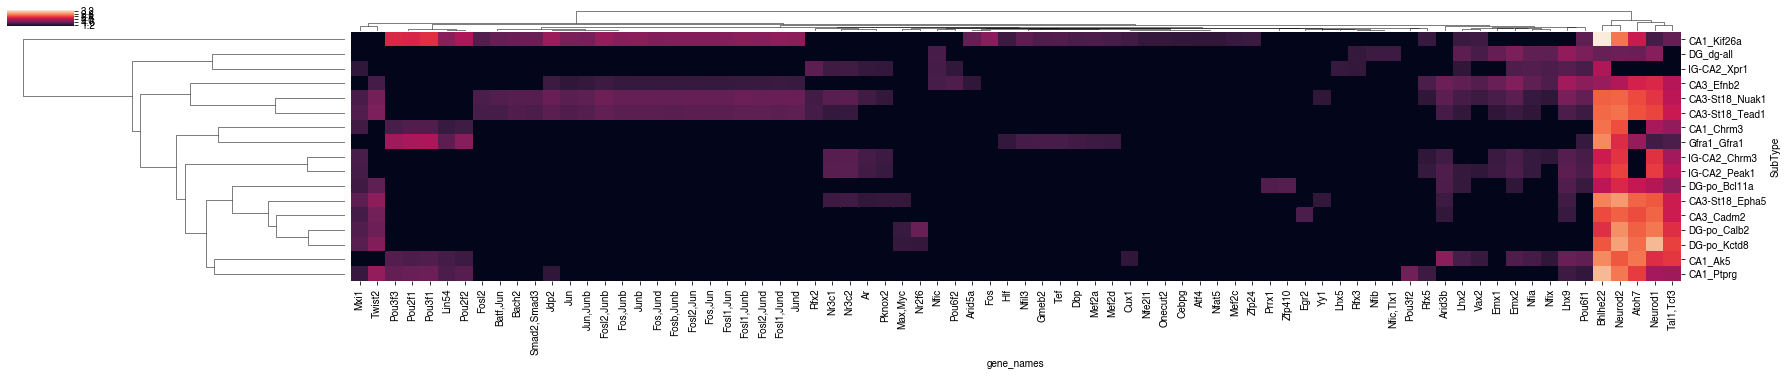

In [40]:
sns.clustermap(enriched_motif.groupby(['SubType', 'gene_names'])['oddsratio'].max().unstack().fillna(1),
              figsize=(30, 5))

In [43]:
enriched_motif['motif_group'].value_counts().size

31

In [45]:
enriched_motif.to_msgpack('MotifEnrichment.rna_filtered.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
